# Analysis of method repetition in Jetbrains 10M Notebook dataset on a subset of 15k notebook files



In [145]:
import json
import pandas as pd
import warnings
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [146]:
N = 15000
SNS_PALETTE = "husl"
json_file_path = '../../../../data/notebooks/annotated_jetbrains_optim_15k.json'

warnings.filterwarnings("ignore")
data = json.load(open(json_file_path))

In [147]:
n_files= len(data.keys())
n_files

14916

Due to validation errors, this analisys entails less than N = 15000 files. (Above)

## Simple module analysis

In [148]:
filenames = data.keys();

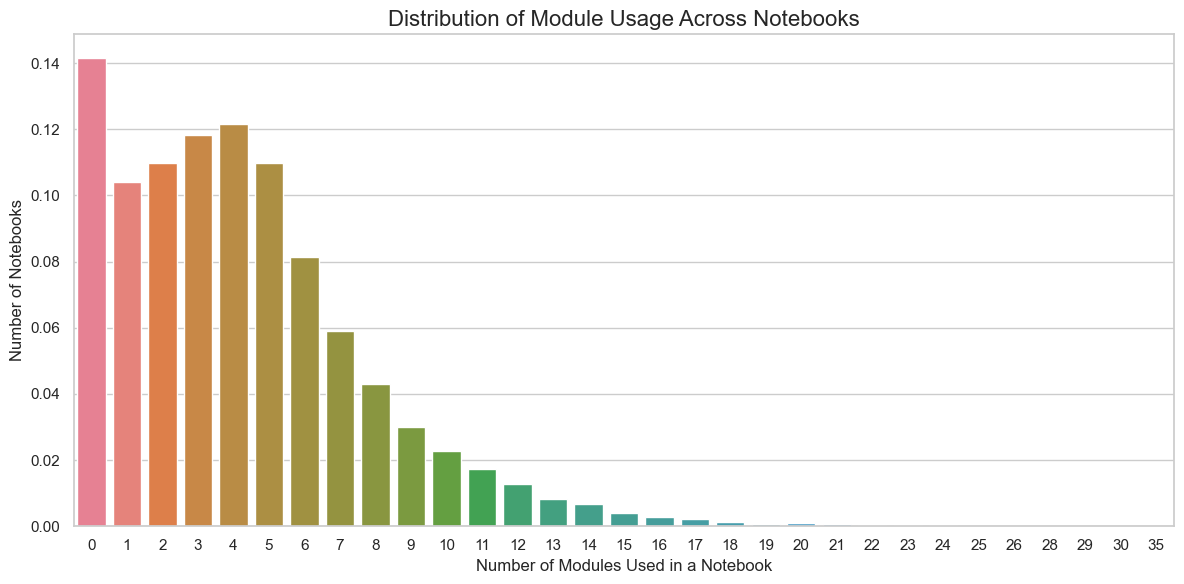

In [149]:
def get_module_occurence_plot(module_occurence):
    module_occurence_histogram = Counter(module_occurence)

    x_values = list(module_occurence_histogram.keys())  # Number of modules used
    y_values = np.array(list(module_occurence_histogram.values())) / n_files  # Frequency of that usage count

    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(12, 6))
    sns.barplot(x=x_values, y=y_values, palette=SNS_PALETTE)

    plt.xlabel("Number of Modules Used in a Notebook", fontsize=12)
    plt.ylabel("Number of Notebooks", fontsize=12)
    plt.title("Distribution of Module Usage Across Notebooks", fontsize=16)

    plt.tight_layout()
    plt.show()

module_occurence = [len(data[filename].keys()) for filename in filenames]
get_module_occurence_plot(module_occurence)

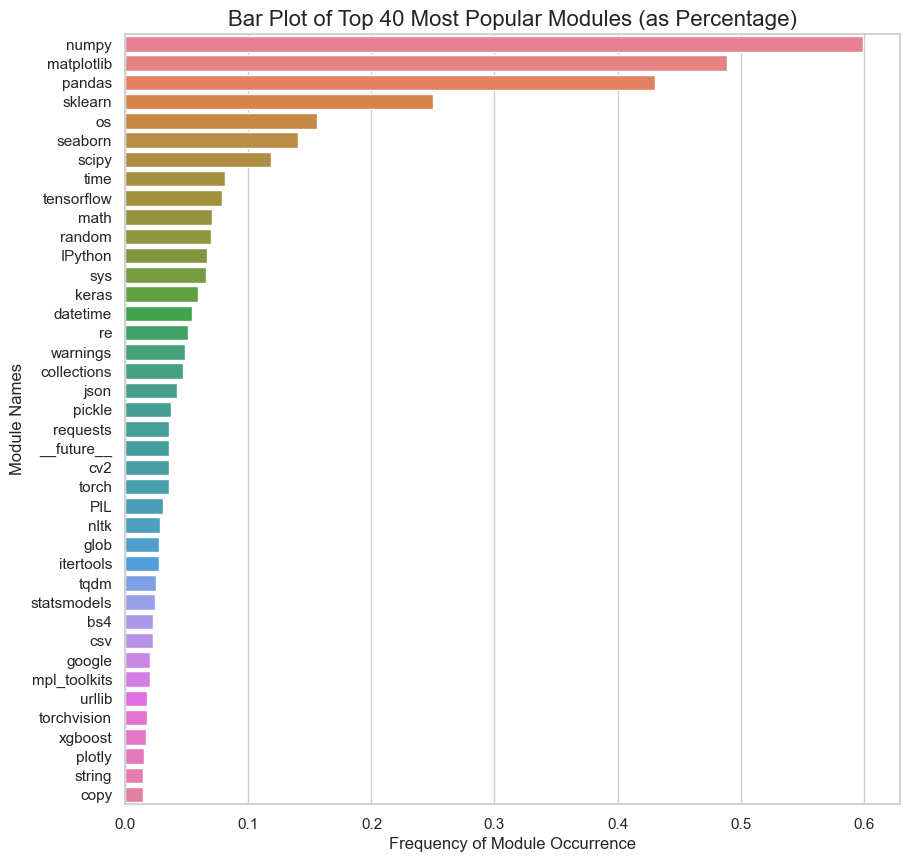

In [150]:
def get_top_used_modules(module_names, title = ''):
    module_histogram = Counter(module_names)
    top_40_modules = module_histogram.most_common(40)
    module_names_top_40 = [module for module, _ in top_40_modules]
    frequencies_top_40 = [freq/n_files for _, freq in top_40_modules]

    sns.set_theme(style="whitegrid")

    plt.figure(figsize=(10, 10))
    sns.barplot(x=frequencies_top_40, y=module_names_top_40, palette="husl")

    plt.xlabel("Frequency of Module Occurrence", fontsize=12)
    plt.ylabel("Module Names", fontsize=12)
    plt.title(title, fontsize=16)
    plt.show()


module_names = [module for filename in filenames for module in data[filename].keys()]
get_top_used_modules(module_names, title = "Bar Plot of Top 40 Most Popular Modules (as Percentage)")

## Conservative analysis of used modules by simple regex (can include comments)

In [151]:
filenames;

The distribution plot looks quite similar to the original one, not taking under account what imports were unused. Look at plot below to learn more about how imports are omitted (35% of notebooks oit AT LEAST one import!)

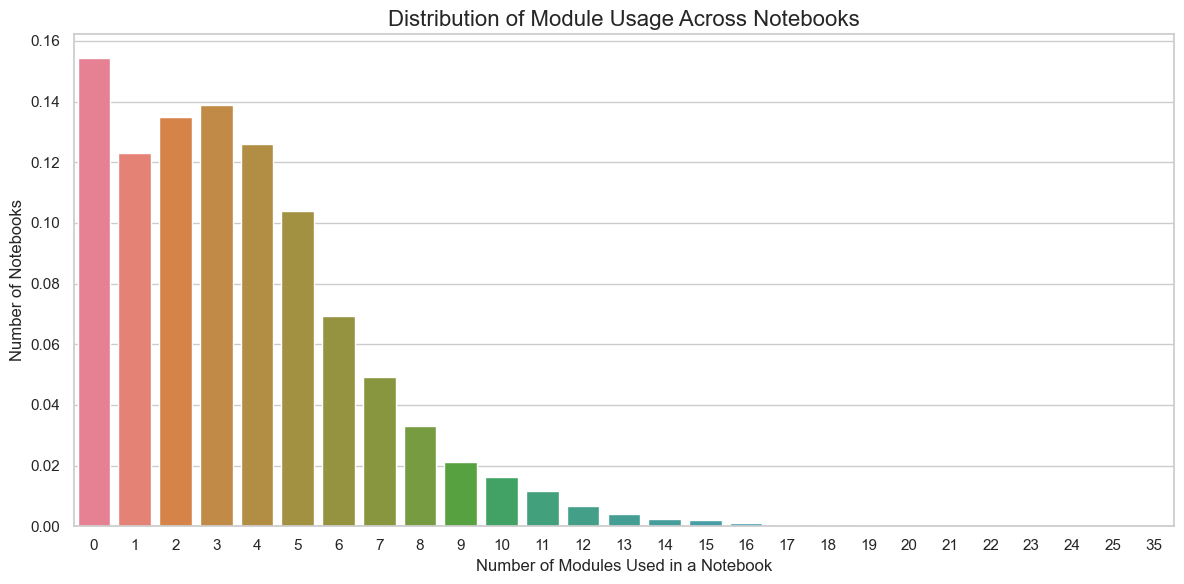

In [152]:
module_occurence_simple_check = [
    sum(
        any(data[filename][module][cell]['regex_presence_check'] for cell in data[filename][module])
        for module in data[filename].keys()
    )
    for filename in filenames
]

get_module_occurence_plot(module_occurence_simple_check)


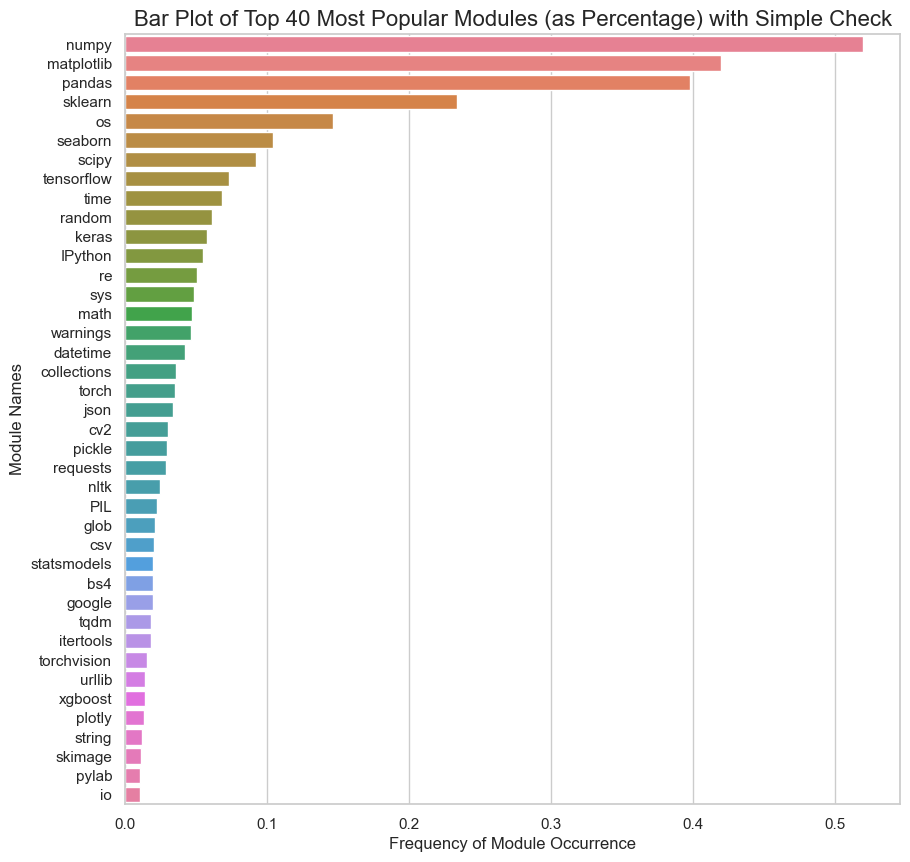

In [153]:
module_names_simple_check = [
    module
    for filename in filenames
    for module in data[filename].keys()
    if any(data[filename][module][cell]['regex_presence_check'] for cell in data[filename][module])
]

get_top_used_modules(module_names_simple_check, title = "Bar Plot of Top 40 Most Popular Modules (as Percentage) with Simple Check")

### Let's look at the unused imports (conservative assesment)

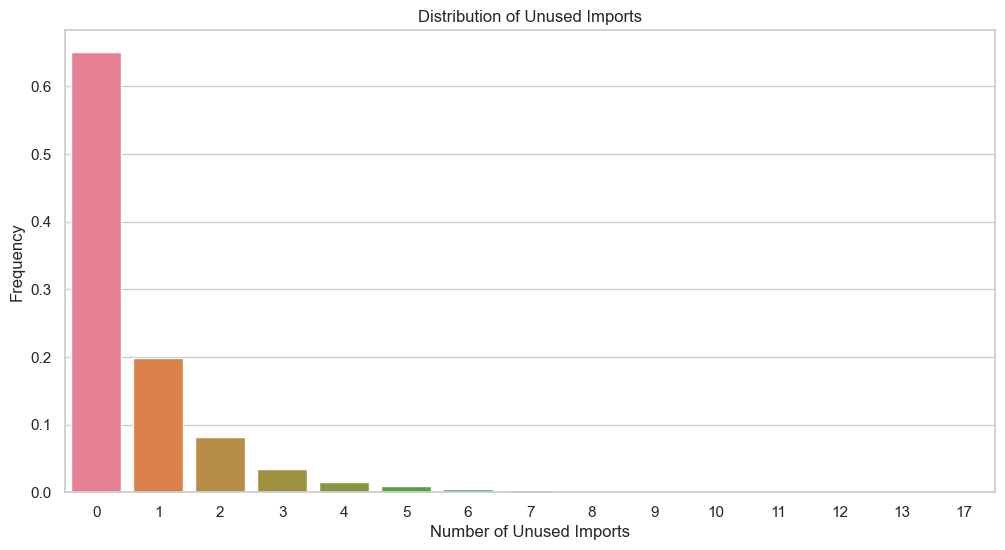

In [154]:
unused_imports = np.array(module_occurence) - np.array(module_occurence_simple_check)

module_occurence_simple_check_histogram = Counter(unused_imports)
x_values = list(module_occurence_simple_check_histogram.keys())
y_values = np.array(list(module_occurence_simple_check_histogram.values()))/n_files
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.barplot(x=x_values, y=y_values, palette=SNS_PALETTE)

plt.xlabel('Number of Unused Imports')
plt.ylabel('Frequency')
plt.title('Distribution of Unused Imports')
plt.show()

35% of notebooks omit at least ine import!

In [155]:
1 - module_occurence_simple_check_histogram[np.int64(0)]/n_files

0.34949048002145344

### What exactly are the most omitted imports? (conservative assesment)


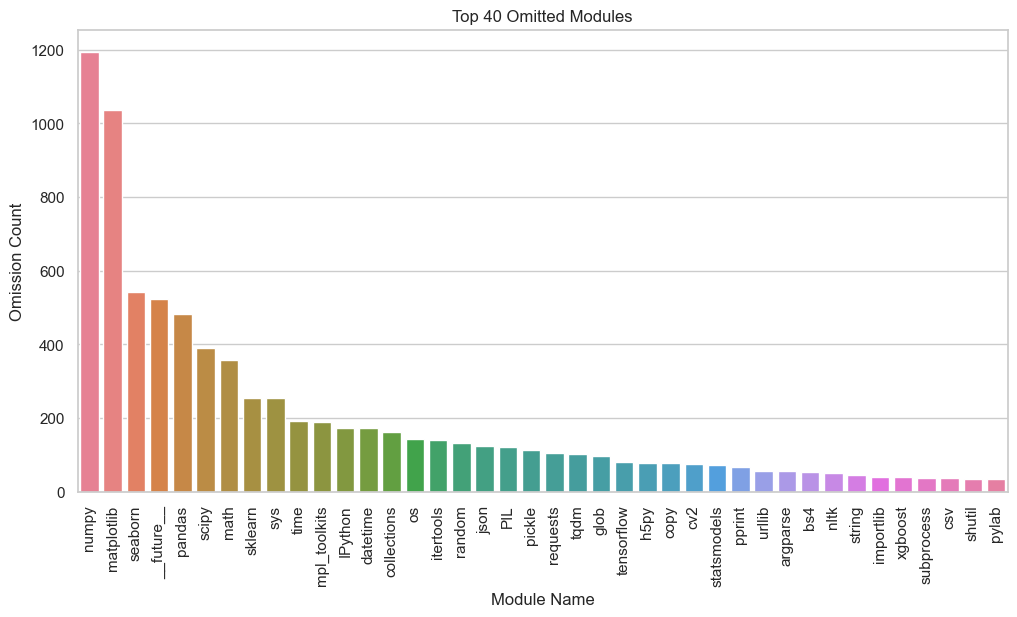

In [156]:
counted_modules_filtered_simple_check = Counter(module_names_simple_check)
counted_modules = Counter(module_names)

omitted_modules = dict([(module, count - counted_modules_filtered_simple_check[module]) for module, count in counted_modules.items() ])
top_omitted_modules = dict(sorted(omitted_modules.items(), key=lambda item: item[1], reverse=True)[:40])

x_values = list(top_omitted_modules.keys())
y_values = list(top_omitted_modules.values())

sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.barplot(x=x_values, y=y_values, palette=SNS_PALETTE)

plt.xlabel('Module Name')
plt.ylabel('Omission Count')
plt.title('Top 40 Omitted Modules')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

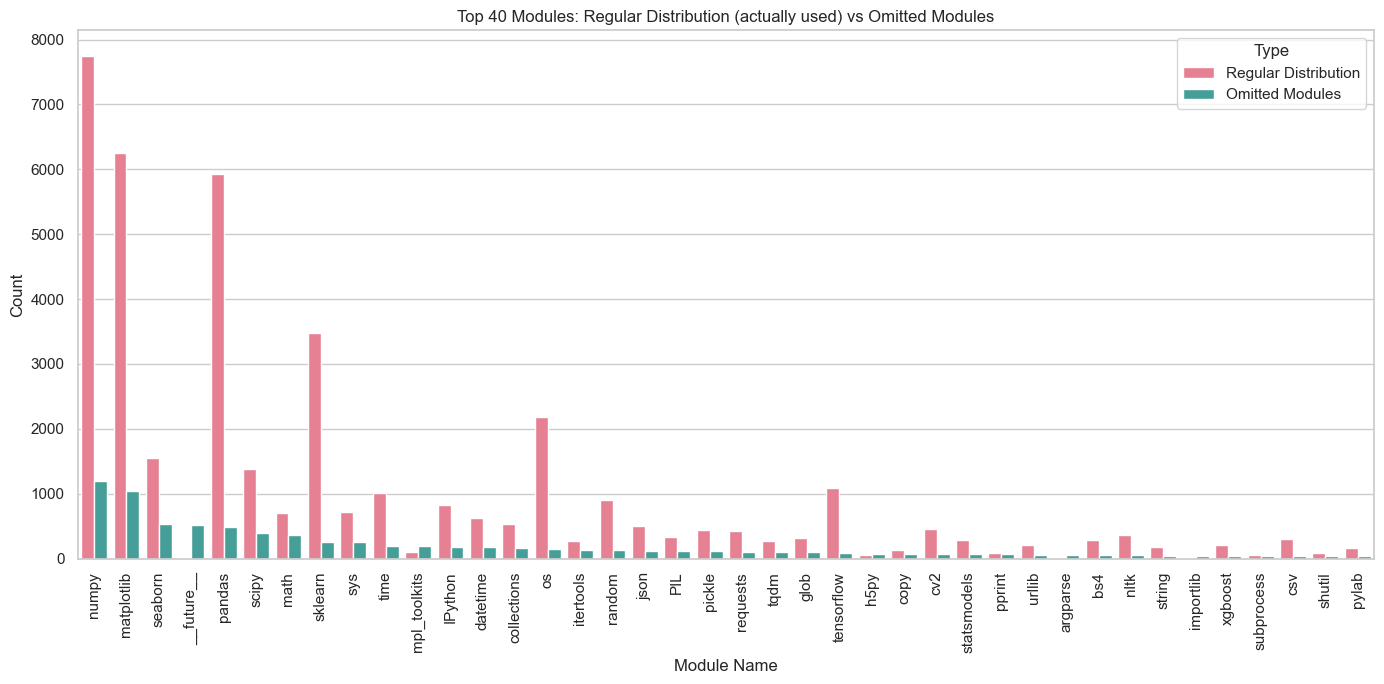

In [157]:
top_modules = list(top_omitted_modules.keys())
omitted_counts = [top_omitted_modules[module] for module in top_modules]
regular_counts = [counted_modules_filtered_simple_check[module] for module in top_modules]

df = pd.DataFrame({
    'Module': top_modules,
    'Regular Distribution': regular_counts,
    'Omitted Modules': omitted_counts
})

df_melted = df.melt(id_vars='Module', var_name='Type', value_name='Count')

sns.set_theme(style="whitegrid")
plt.figure(figsize=(14, 7))
sns.barplot(x='Module', y='Count', hue='Type', data=df_melted, palette=SNS_PALETTE)

plt.xlabel('Module Name')
plt.ylabel('Count')
plt.title('Top 40 Modules: Regular Distribution (actually used) vs Omitted Modules')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.legend(title='Type')

plt.tight_layout()
plt.show()

## Let's look at what methods the modules were used directly and check occurence is a less conservative approach

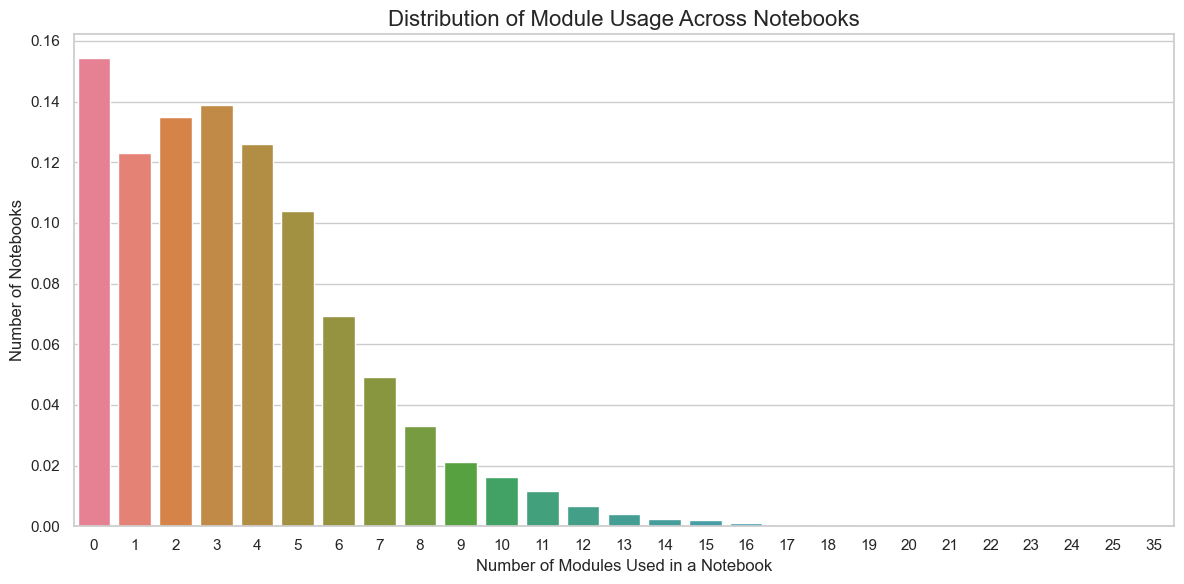

In [158]:
module_occurence_method_check = [
    sum(
        1 
        for module  in data[filename].keys()
        if any([len(data[filename][module][key]['methods_used']) > 0 for key in data[filename][module].keys()])
    )
    for filename in filenames
    
]

get_module_occurence_plot(module_occurence_simple_check)

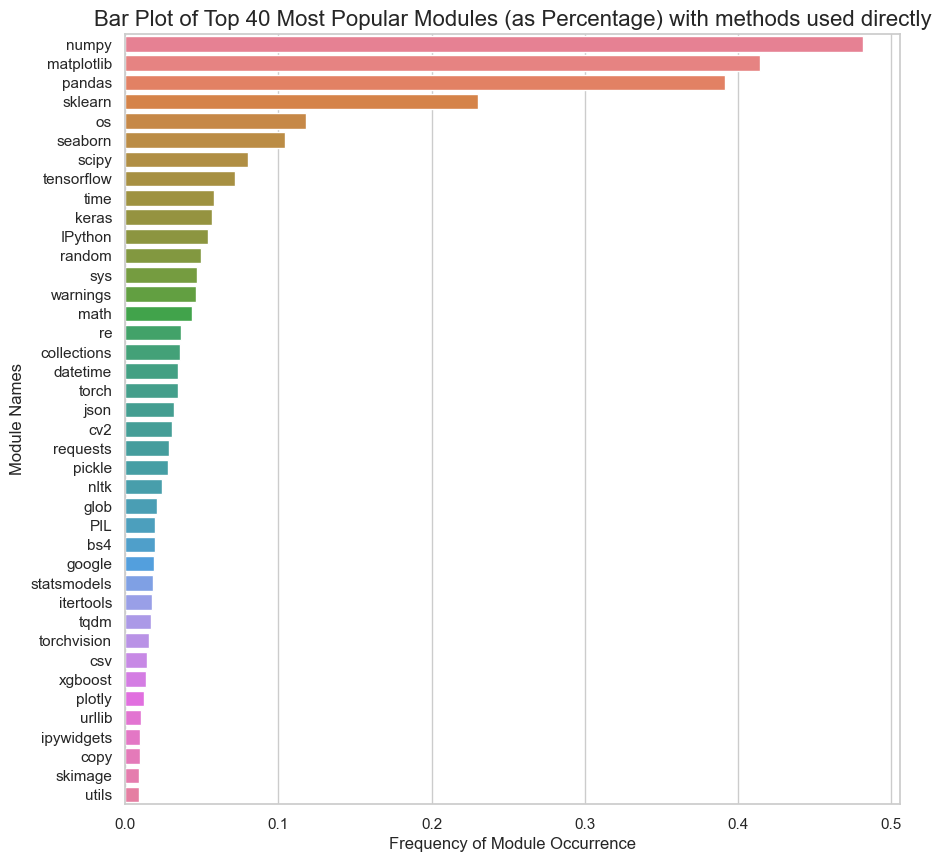

In [159]:
module_names_liberal_check = [
    module
    for filename in filenames
    for module in data[filename].keys()
    if any([len(data[filename][module][key]['methods_used']) > 0 for key in data[filename][module].keys()])
]

get_top_used_modules(module_names_liberal_check, title = "Bar Plot of Top 40 Most Popular Modules (as Percentage) with methods used directly")

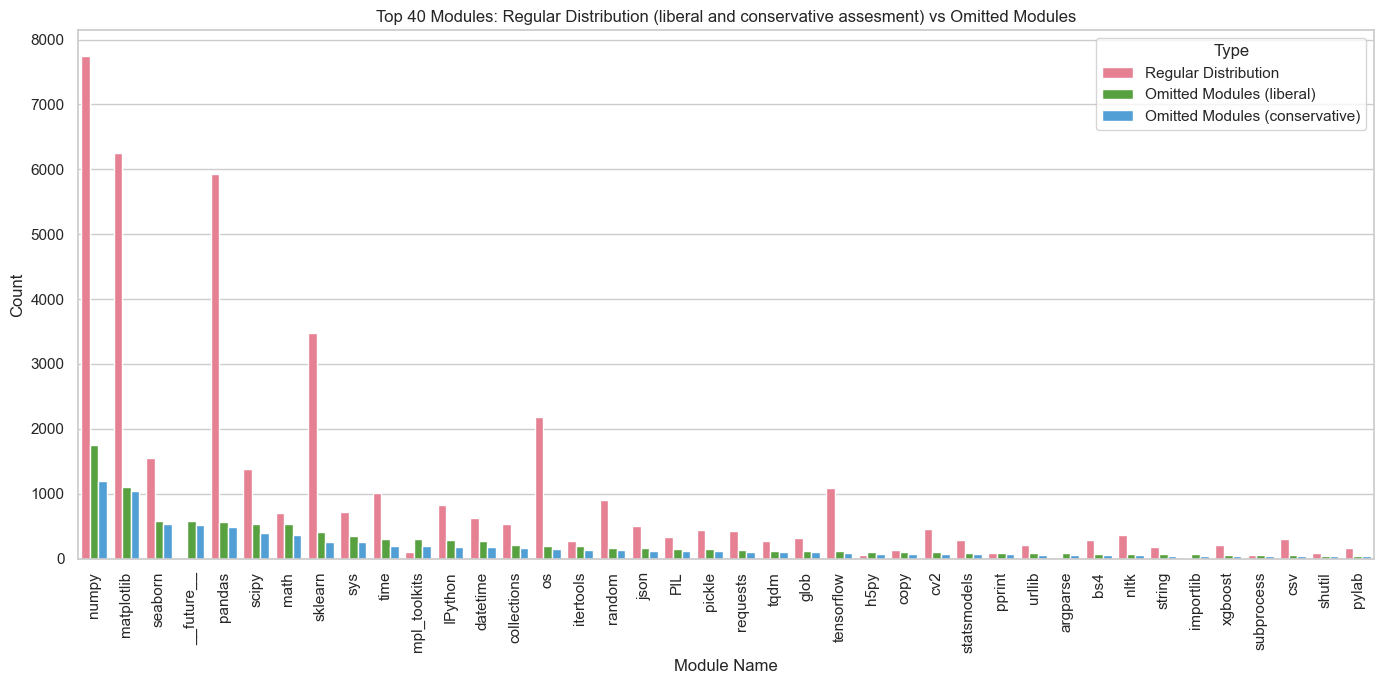

In [160]:
counted_modules_filtered_liberal_check = Counter(module_names_liberal_check)
counted_modules = Counter(module_names)

omitted_modules_liberal = dict([(module, count - counted_modules_filtered_liberal_check[module]) for module, count in counted_modules.items() ])
top_omitted_modules_liberal = dict(sorted(omitted_modules_liberal.items(), key=lambda item: item[1], reverse=True)[:40])

top_modules_liberal = list(top_omitted_modules_liberal.keys())
omitted_counts_liberal = [top_omitted_modules_liberal[module] for module in top_modules_liberal]

df = pd.DataFrame({
    'Module': top_modules,
    'Regular Distribution': regular_counts,
    'Omitted Modules (liberal)': omitted_counts_liberal,
    'Omitted Modules (conservative)': omitted_counts
})

df_melted = df.melt(id_vars='Module', var_name='Type', value_name='Count')

sns.set_theme(style="whitegrid")
plt.figure(figsize=(14, 7))
sns.barplot(x='Module', y='Count', hue='Type', data=df_melted, palette=SNS_PALETTE)

plt.xlabel('Module Name')
plt.ylabel('Count')
plt.title('Top 40 Modules: Regular Distribution (liberal and conservative assesment) vs Omitted Modules')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.legend(title='Type')

plt.tight_layout()
plt.show()

### What exactly are the most omitted imports? (liberal assesment)

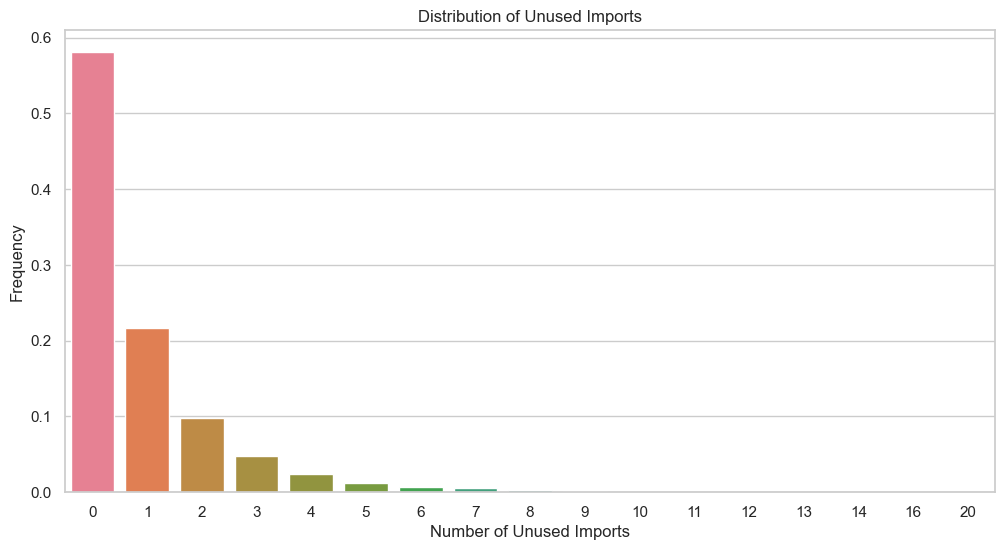

In [161]:
unused_imports = np.array(module_occurence) - np.array(module_occurence_method_check)

module_occurence_method_check_histogram = Counter(unused_imports)
x_values = list(module_occurence_method_check_histogram.keys())
y_values = np.array(list(module_occurence_method_check_histogram.values()))/n_files
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.barplot(x=x_values, y=y_values, palette=SNS_PALETTE)

plt.xlabel('Number of Unused Imports')
plt.ylabel('Frequency')
plt.title('Distribution of Unused Imports')
plt.show()

In [162]:
1 - module_occurence_method_check_histogram[np.int64(0)]/n_files

0.41914722445695896

Recap: A liberal assesment is when a module or imported method actually was called via an attribute call: like (Universe.PTB) or method call (Universe.create_flat_earth()) or instantiation  ( Universe()). It differs from the conservative assesment which only checks for the presence of 'Universe' in the code.

By counting module usage liberally we get an even higher count of notebooks with at least one import unused: 42$

### Coexisting imports of modules in the liberal count.

In [163]:
module_names_liberal_lists = [
    [module
    for module in data[filename].keys()
    if any([len(data[filename][module][key]['methods_used']) > 0 for key in data[filename][module].keys()])]
    for filename in filenames
]

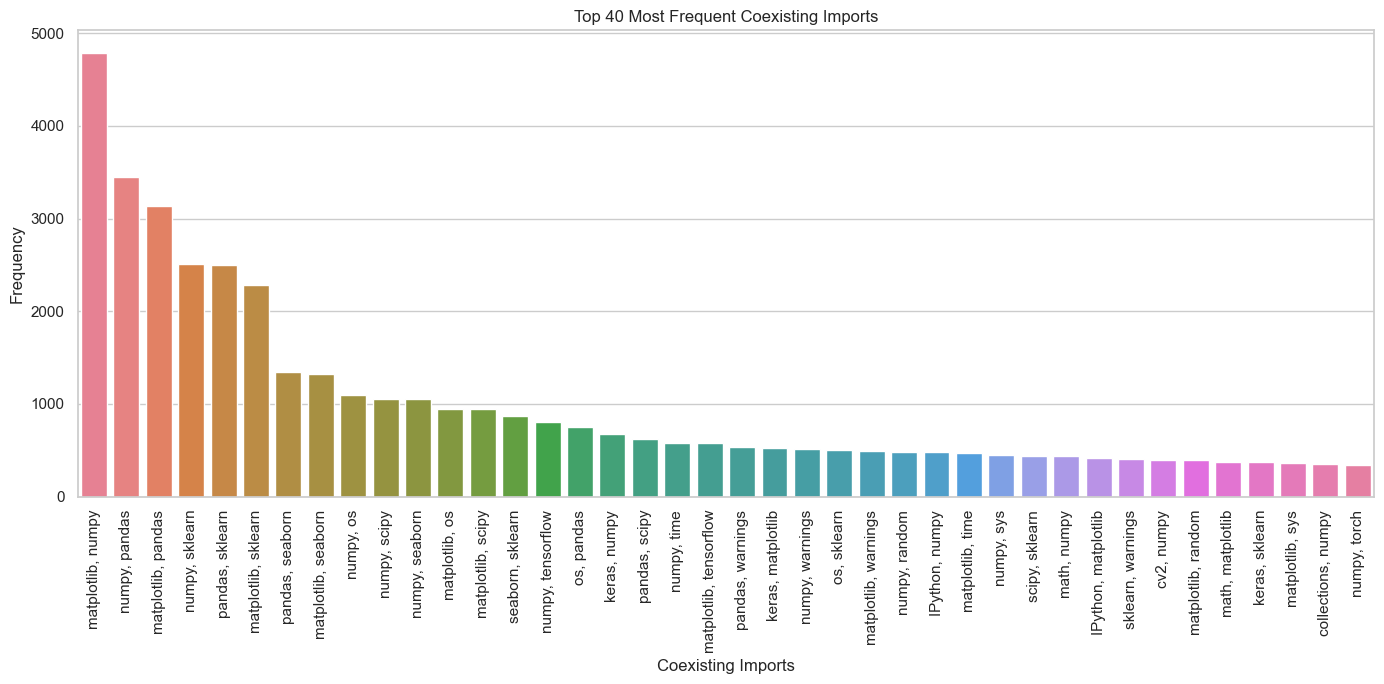

In [164]:
from itertools import combinations


def plot_top_coexisting_imports(module_names_liberal, top_n=40, title_what = 'Imports'):
    """
    Plots the top N most frequent coexisting imports from the given module names.

    :param module_names_liberal: List of lists containing module names.
    :param top_n: Number of top coexisting imports to plot.
    """
    coexisting_imports = Counter()
    for modules in module_names_liberal:
        for combo in combinations(modules, 2):
            coexisting_imports[tuple(sorted(combo))] += 1

    top_coexisting_imports = coexisting_imports.most_common(top_n)

    x_values = [', '.join(combo) for combo, _ in top_coexisting_imports]
    y_values = [count for _, count in top_coexisting_imports]

    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(14, 7))
    sns.barplot(x=x_values, y=y_values, palette=SNS_PALETTE)
    plt.xlabel('Coexisting Imports')
    plt.ylabel('Frequency')
    plt.title(f'Top {top_n} Most Frequent Coexisting {title_what}')
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

    plt.tight_layout()
    plt.show()

plot_top_coexisting_imports(module_names_liberal_lists)

### Methods Used

Disclaimer this analysis is a lower bound to module methods used. The methods counted here need to be direclty imported or be colled by the imported module!

In [165]:
methods_used_in_notebook = [
    (
        value['module'] + '.' + 
        (value['submodule'] if value['submodule'] != '' else (value['methods'] if value['methods'] != '-' and value['methods'] != method_name else '')) + 
        ('.' if value['submodule'] != '' or (value['methods'] != '-' and value['methods'] != method_name) else '') + 
        method_name
    )
    for filename in filenames
    for module in data[filename].keys()
    if any(len(data[filename][module][key]['methods_used']) > 0 for key in data[filename][module].keys())
    for _, value in data[filename][module].items()
    for method_name, method_occurence in value['methods_used'].items()
    
]

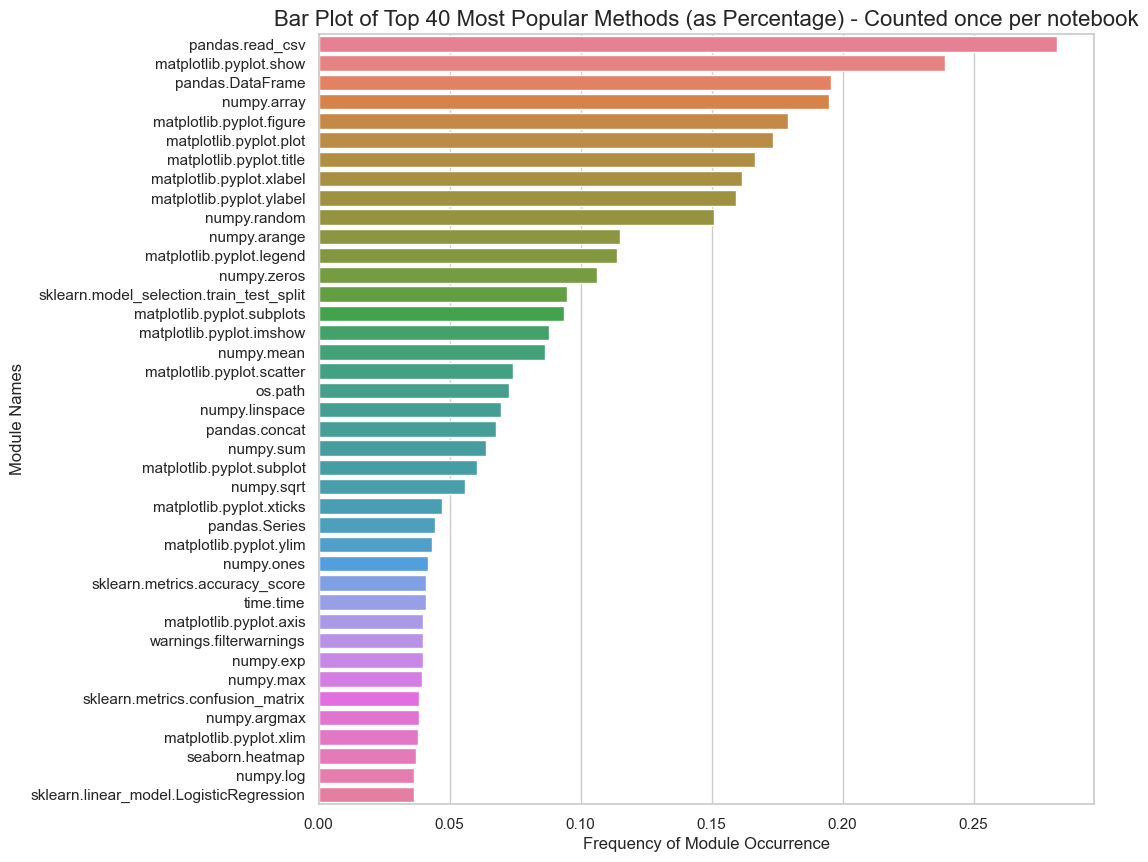

In [166]:
get_top_used_modules(methods_used_in_notebook, title = "Bar Plot of Top 40 Most Popular Methods (as Percentage) - Counted once per notebook")

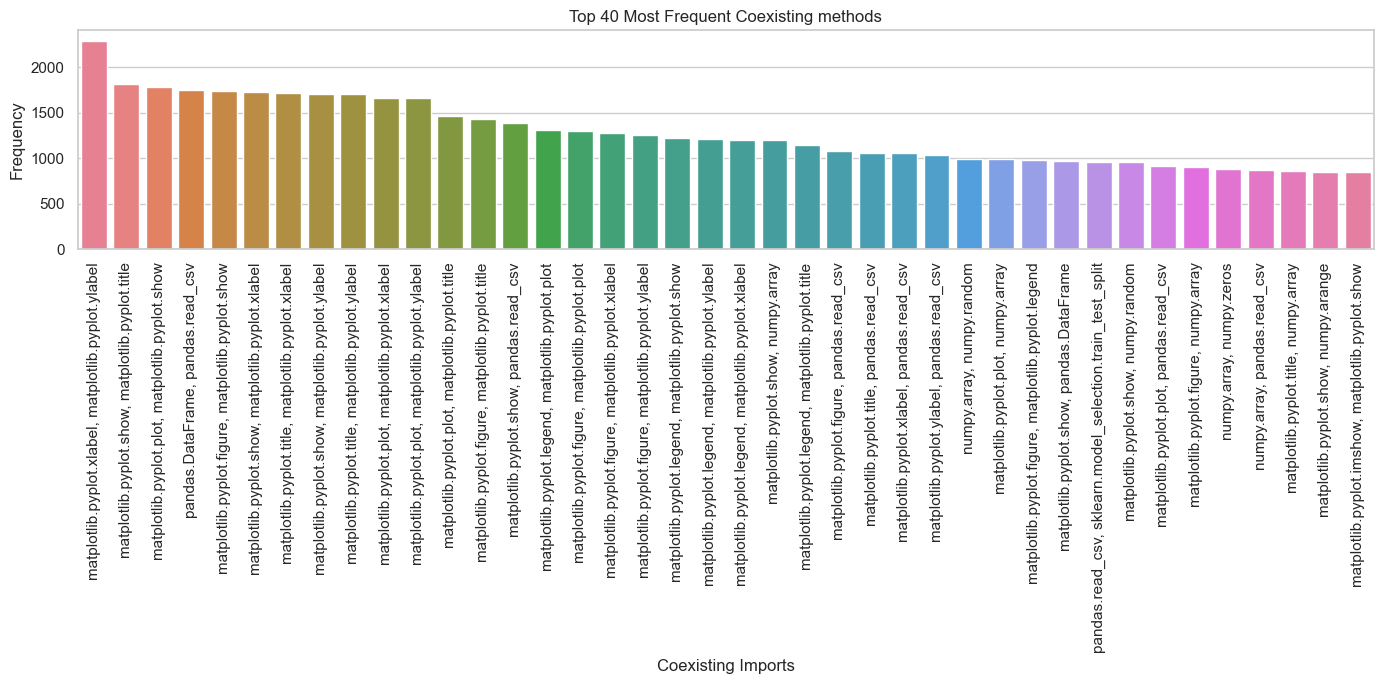

In [167]:
methods_used_in_notebook_per_notebook = [
    [
        value['module'] + '.' + 
        (value['submodule'] if value['submodule'] != '' else (value['methods'] if value['methods'] != '-' and value['methods'] != method_name else '')) + 
        ('.' if value['submodule'] != '' or (value['methods'] != '-' and value['methods'] != method_name) else '') + 
        method_name
    
    for module in data[filename].keys()
    if any(len(data[filename][module][key]['methods_used']) > 0 for key in data[filename][module].keys())
    for _, value in data[filename][module].items()
    for method_name, method_occurence in value['methods_used'].items()]
    for filename in filenames
]
plot_top_coexisting_imports(methods_used_in_notebook_per_notebook, title_what='methods')